In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

In [8]:
df = pd.read_csv("user_behavior_dataset.csv")
df = df.drop(columns=['User_ID','Age'])
df.head()

,Device_Model,Operating_System,App_Usage_Time,Screen_On_Time,Battery_Drain,Number_of_Apps_Installed,Data_Usage,Gender,User_Behavior_Class
0,Google Pixel 5,Android,393,6.4,1872,67,1122,Male,4
1,OnePlus 9,Android,268,4.7,1331,42,944,Female,3
2,Xiaomi Mi 11,Android,154,4.0,761,32,322,Male,2
3,Google Pixel 5,Android,239,4.8,1676,56,871,Male,3
4,iPhone 12,iOS,187,4.3,1367,58,988,Female,3


In [9]:
x = df.drop(columns=['Screen_On_Time'])
y = df['Screen_On_Time']

x_encoded = pd.get_dummies(x)
X_train, X_test, y_train, y_test = train_test_split(x_encoded, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [57]:
rf = RandomForestRegressor(
    n_estimators=200,
    min_samples_leaf=5,
    min_samples_split=10,
    max_depth=None,
    max_features='log2',
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

print("Random Forest Regressor Performance:")
print("  MSE:", mean_squared_error(y_test, y_pred_rf))
print("  R2 Score:", r2_score(y_test, y_pred_rf))

Random Forest Regressor Performance:
  MSE: 0.5058478924432878
  R2 Score: 0.943621952131073


In [35]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = { #hypertuning to find the best parameters for the model
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [3, 5, 6, 8, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_alpha": [0, 0.01, 0.1, 1],
    "reg_lambda": [1, 1.5, 2, 3]
}
xgb = XGBRegressor(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=30,
    scoring='r2',
    verbose=1,
)
random_search.fit(X_train_scaled, y_train)
best_model = random_search.best_estimator_

y_pred_xgb = best_model.predict(X_test_scaled)

print("MSE:", mean_squared_error(y_test, y_pred_xgb))
print("R^2:", r2_score(y_test, y_pred_xgb))
print("Best Parameters:", random_search.best_params_) # to show the best parameter values that have been used


Fitting 5 folds for each of 30 candidates, totalling 150 fits
MSE: 0.55028496516434
R^2: 0.9386693261530902
Best Parameters: {'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alpha': 0.01, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.8}


Text(0.5, 1.0, 'Random Forest Regressor - Actual vs Predicted')

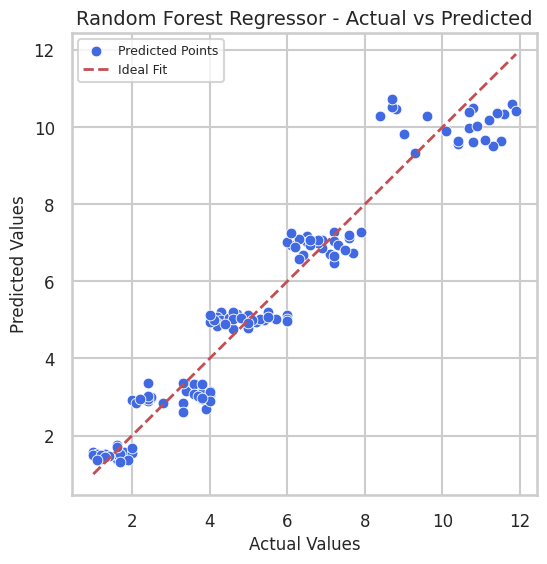

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred_rf, color='royalblue', edgecolor='w', s=60, label='Predicted Points')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2, label='Ideal Fit')
plt.legend(fontsize=9)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Actual Values', fontsize = 12)
plt.ylabel('Predicted Values', fontsize = 12)
plt.title('Random Forest Regressor - Actual vs Predicted', fontsize = 14)

Text(0.5, 1.0, 'XGBoost Regressor - Actual vs Predicted')

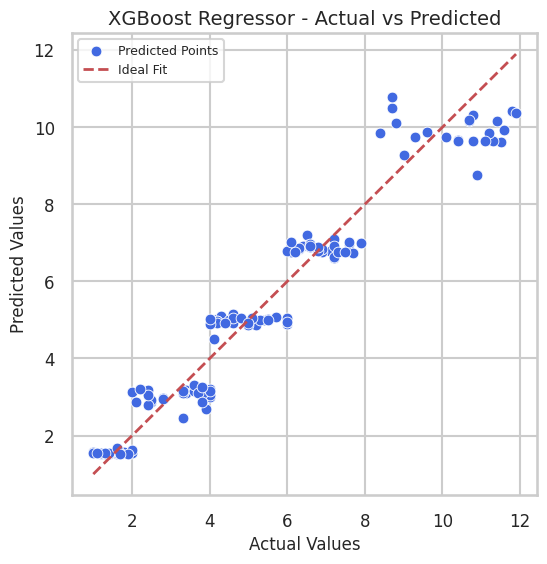

In [50]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred_xgb, color='royalblue', edgecolor='w', s=60, label='Predicted Points')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2, label='Ideal Fit')
plt.legend(fontsize=9)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Actual Values', fontsize = 12)
plt.ylabel('Predicted Values', fontsize = 12)
plt.title('XGBoost Regressor - Actual vs Predicted', fontsize = 14)
